In [2]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt


In [3]:
from sklearn.datasets import make_circles
n_samples=1000
X,y=make_circles(n_samples,noise=0.04,random_state=57)
print(f"first 10 features X:\{X[:10]}")
print(f"first 10 features y:\{y[:10]}")


first 10 features X:\[[-0.81151845 -0.19922408]
 [-0.39696456 -0.93848064]
 [ 0.35666087  0.91975483]
 [ 0.81732306  0.1787241 ]
 [-0.65409765 -0.78426554]
 [-0.74139433 -0.39271721]
 [ 0.89103897 -0.51017034]
 [ 0.54510988  0.85016263]
 [ 0.62089228  0.73480227]
 [ 0.03858174 -0.96787343]]
first 10 features y:\[1 0 0 1 0 1 0 0 0 0]


In [4]:
import pandas as pd
circles=pd.DataFrame({"X1": X[:,0],
"X2": X[:,1],"label": y})
circles.head()

,X1,X2,label
0,-0.811518,-0.199224,1
1,-0.396965,-0.938481,0
2,0.356661,0.919755,0
3,0.817323,0.178724,1
4,-0.654098,-0.784266,0


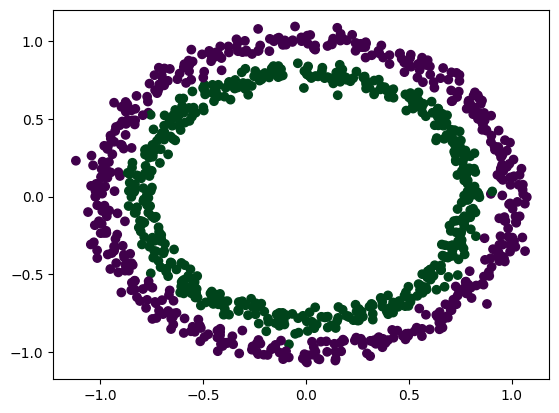

In [5]:
plt.scatter(x=X[:,0],y=X[:,1],c=y,cmap=plt.cm.PRGn)

In [6]:
X.shape, y.shape

((1000, 2), (1000,))

In [7]:

X_sample=X[0]
Y_sample=y[0]

In [8]:
X=torch.from_numpy(X).type(torch.float)
y=torch.from_numpy(y).type(torch.float)
X[:5],y[:5]

(tensor([[-0.8115, -0.1992],
         [-0.3970, -0.9385],
         [ 0.3567,  0.9198],
         [ 0.8173,  0.1787],
         [-0.6541, -0.7843]]),
 tensor([1., 0., 0., 1., 0.]))

In [9]:
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=35)

In [10]:
device="cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [11]:
class CircleClassifier(nn.Module):
    def __init__(self) -> None:
        super().__init__()
        self.layer_1=nn.Linear(in_features=2, out_features=10)
        self.layer_2=nn.Linear(in_features=10,out_features=10)
        self.layer_3=nn.Linear(in_features=10,out_features=1)
        self.relu=nn.ReLU()
    def forward(self,x):
        return self.layer_3(self.relu(self.layer_2(self.relu(self.layer_1(x)))))

model1=CircleClassifier().to(device)
model1

CircleClassifier(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [12]:
untrained_preds=model1(X_test.to(device))

In [13]:
def accuracy_function(y_true,y_pred):
    correct=torch.eq(y_true,y_pred).sum().item()
    acc=(correct/len(y_pred))*100
    return acc

In [14]:
loss_func=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model1.parameters(),lr=0.1)

In [15]:
torch.manual_seed(42)
epochs=1500
X_train,y_train = X_train.to(device),y_train.to(device)
X_test,y_test=X_test.to(device),y_test.to(device)
for epoch in range(epochs):
    model1.train()
    y_logist=model1(X_train).squeeze()
    y_pred=torch.round(torch.sigmoid(y_logist))

    loss=loss_func(y_logist,y_train)
    acc=accuracy_function(y_true=y_train,y_pred=y_pred)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    model1.eval()
    with torch.inference_mode():
        test_logits=model1(X_test).squeeze()
        test_pred=torch.round(torch.sigmoid(test_logits))

        test_loss=loss_func(test_logits,y_test)

        test_acc=accuracy_function(y_true=y_test,y_pred=test_pred)
    if epoch%100==0:
        print(f"Eproch: {epoch}, Loss {loss:.5f}, Accuracy:{acc}:2f%  Test Loss: {test_loss:.5f},Test accuracy {test_acc:.2f}%")

Eproch: 0, Loss 0.70220, Accuracy:50.0:2f%  Test Loss: 0.70450,Test accuracy 48.50%
Eproch: 100, Loss 0.69065, Accuracy:50.74999999999999:2f%  Test Loss: 0.69315,Test accuracy 49.50%
Eproch: 200, Loss 0.68631, Accuracy:53.25:2f%  Test Loss: 0.68887,Test accuracy 50.50%
Eproch: 300, Loss 0.68028, Accuracy:55.25:2f%  Test Loss: 0.68316,Test accuracy 54.50%
Eproch: 400, Loss 0.67140, Accuracy:63.0:2f%  Test Loss: 0.67489,Test accuracy 60.50%
Eproch: 500, Loss 0.65643, Accuracy:77.125:2f%  Test Loss: 0.66164,Test accuracy 72.00%
Eproch: 600, Loss 0.62816, Accuracy:85.375:2f%  Test Loss: 0.63707,Test accuracy 77.50%
Eproch: 700, Loss 0.57154, Accuracy:89.5:2f%  Test Loss: 0.58450,Test accuracy 85.00%
Eproch: 800, Loss 0.47235, Accuracy:93.375:2f%  Test Loss: 0.48474,Test accuracy 89.50%
Eproch: 900, Loss 0.33484, Accuracy:97.875:2f%  Test Loss: 0.34075,Test accuracy 95.50%
Eproch: 1000, Loss 0.21439, Accuracy:98.875:2f%  Test Loss: 0.21542,Test accuracy 98.00%
Eproch: 1100, Loss 0.16380, Ac

In [18]:
def plot_decision_boundary(model: torch.nn.Module, X: torch.Tensor, y: torch.Tensor):
    model.to("cpu")
    X, y = X.to("cpu"), y.to("cpu")
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 101), np.linspace(y_min, y_max, 101))
    X_to_pred_on = torch.from_numpy(np.column_stack((xx.ravel(), yy.ravel()))).float()
    model.eval()
    with torch.inference_mode():
        y_logits = model(X_to_pred_on)
    if len(torch.unique(y)) > 2:
        y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1)
    else:
        y_pred = torch.round(torch.sigmoid(y_logits))
    y_pred = y_pred.reshape(xx.shape).detach().numpy()
    plt.contourf(xx, yy, y_pred, cmap=plt.cm.RdYlBu, alpha=0.7)
    plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.RdYlBu)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())

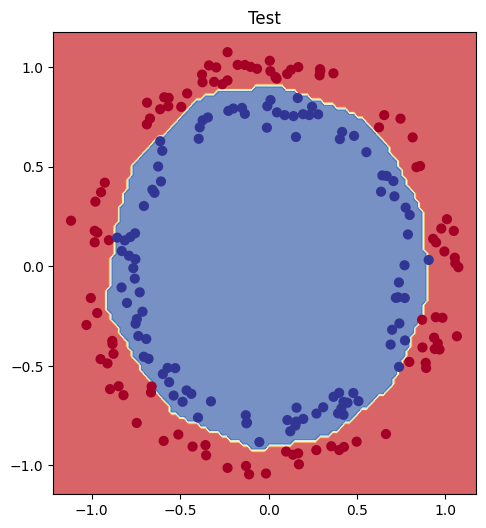

In [20]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model1, X_test, y_test)